Target NP

In [1]:
import numpy as np
import tensorflow as tf

C:\Users\Royce\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
sess = tf.Session()

In [3]:
# numpy格式的回归目标
def regress_target_np(anchors, gt_boxes):
    """
    计算回归目标
    :param anchors: [N,(y1,x1,y2,x2)]
    :param gt_boxes: [N,(y1,x1,y2,x2)]
    :return: [N,(dy, dx, dh, dw)] # 这里anchor与gt是一一对应关系
    """
    # 高度和宽度
    h = anchors[:, 2] - anchors[:, 0]
    w = anchors[:, 3] - anchors[:, 1]
    # GT的高度与宽度
    gt_h = gt_boxes[:, 2] - gt_boxes[:, 0]
    gt_w = gt_boxes[:, 3] - gt_boxes[:, 1]
    # 中心点
    center_y = (anchors[:, 2] + anchors[:, 0]) * 0.5
    center_x = (anchors[:, 3] + anchors[:, 1]) * 0.5
    gt_center_y = (gt_boxes[:, 2] + gt_boxes[:, 0]) * 0.5
    gt_center_x = (gt_boxes[:, 3] + gt_boxes[:, 1]) * 0.5
    # 回归目标
    dy = (gt_center_y - center_y) / h
    dx = (gt_center_x - center_x) / w
    dh = np.log(gt_h / h)
    dw = np.log(gt_w / w)
    target = np.stack([dy, dx, dh, dw], axis=1) # 实际上就是做了个矩阵的转置，变成[[dy,dx,dh,dw],[...]]的形式（这里dy...是单个标量）
    target /= np.array([0.1, 0.1, 0.2, 0.2])
    return target

In [4]:
gt_boxes = np.array([[22,78,304,253],[19,269,296,360]])
anchors = np.array([[15,60,280,260],[50,269,296,360]])
target = regress_target_np(anchors, gt_boxes)

In [5]:
target

array([[ 0.58490566,  0.275     ,  0.31088622, -0.66765696],
       [-0.6300813 ,  0.        ,  0.59342985,  0.        ]])

Target TF

In [6]:
# tf格式的回归目标
def regress_target_tf(anchors, gt_boxes):
    """
    计算回归目标
    :param anchors: [N,(y1,x1,y2,x2)]
    :param gt_boxes: [N,(y1,x1,y2,x2)]
    :return: [N,(dy, dx, dh, dw)]
    """
    # 高度和宽度
    h = anchors[:, 2] - anchors[:, 0]
    w = anchors[:, 3] - anchors[:, 1]
 
    gt_h = gt_boxes[:, 2] - gt_boxes[:, 0]
    gt_w = gt_boxes[:, 3] - gt_boxes[:, 1]
    # 中心点
    center_y = (anchors[:, 2] + anchors[:, 0]) * 0.5
    center_x = (anchors[:, 3] + anchors[:, 1]) * 0.5
    gt_center_y = (gt_boxes[:, 2] + gt_boxes[:, 0]) * 0.5
    gt_center_x = (gt_boxes[:, 3] + gt_boxes[:, 1]) * 0.5
 
    # 回归目标
    dy = (gt_center_y - center_y) / h
    dx = (gt_center_x - center_x) / w
    dh = tf.log(gt_h / h)
    dw = tf.log(gt_w / w)
 
    target = tf.stack([dy, dx, dh, dw], axis=1)
    target /= tf.constant([0.1, 0.1, 0.2, 0.2])
    # target = tf.where(tf.greater(target, 100.0), 100.0, target)
    return target

In [7]:
gt_boxes = np.array([[22,78,304,253],[19,269,296,360]])
anchors = np.array([[15,60,280,260],[50,269,296,360]])
gt_boxes = tf.constant(gt_boxes, dtype=tf.float32)
anchors = tf.constant(anchors, dtype=tf.float32)
target = regress_target_tf(anchors, gt_boxes)

In [8]:
print('回归目标为（标准化之后）:\n{}'.format(sess.run(target)))

回归目标为（标准化之后）:
[[ 0.5849057   0.275       0.31088617 -0.66765696]
 [-0.6300813   0.          0.5934298   0.        ]]


Apply TF

In [9]:
# tf格式的回归目标修正
def apply_regress(deltas, anchors):
    """
    应用回归目标到边框
    :param deltas: 回归目标[N,(dy, dx, dh, dw)]
    :param anchors: anchor boxes[N,(y1,x1,y2,x2)]
    :return:
    """
    # anchors高度和宽度
    h = anchors[:, 2] - anchors[:, 0]
    w = anchors[:, 3] - anchors[:, 1]
 
    # anchors中心点坐标
    cy = (anchors[:, 2] + anchors[:, 0]) * 0.5
    cx = (anchors[:, 3] + anchors[:, 1]) * 0.5
 
    # 回归系数
    deltas *= tf.constant([0.1, 0.1, 0.2, 0.2])
    dy, dx, dh, dw = deltas[:, 0], deltas[:, 1], deltas[:, 2], deltas[:, 3]
    
    # 需要修正的有anchor的中心点坐标值与anchor的长、宽
    # 中心坐标回归
    cy += dy * h
    cx += dx * w
    # 高度和宽度回归
    h *= tf.exp(dh)
    w *= tf.exp(dw)
 
    # 转为y1,x1,y2,x2
    y1 = cy - h * 0.5
    x1 = cx - w * 0.5
    y2 = cy + h * 0.5
    x2 = cx + w * 0.5
 
    return tf.stack([y1, x1, y2, x2], axis=1) # tensor的tf.stack操作，跟numpy的原理一样

In [10]:
deltas = sess.run(target)
anchors = anchors
modify = apply_regress(deltas, anchors)
print('回归修正坐标值为:\n{}'.format(sess.run(modify)))

回归修正坐标值为:
[[ 22.  78. 304. 253.]
 [ 19. 269. 296. 360.]]


样例：target回归与修正

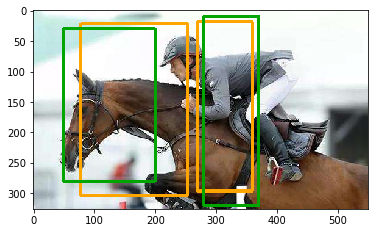

In [13]:
# 示例图片上的anchors与gts的样例
from skimage import io
from matplotlib import pyplot as plt
import cv2
img_path = r'C:\Users\Royce\Desktop\time.jpg'
img = io.imread(img_path)
anchors = np.array([[78,22,253,304],[269,19,360,296]])
gt_boxes = np.array([[50,30,200,280],[280,10,370,320]])
for a in anchors:
    x1,y1,x2,y2 = a
    bbox = cv2.rectangle(img,(x1,y1),(x2,y2),(255, 165, 0),3) # 橙色anchor
for a in gt_boxes:
    x1,y1,x2,y2 = a
    bbox = cv2.rectangle(img,(x1,y1),(x2,y2),(0, 165, 0),3) # 绿色gt
plt.imshow(bbox)

[[ 50.  30. 200. 280.]
 [280.  10. 370. 320.]]
[[ 50.  30. 200. 280.]
 [280.  10. 370. 320.]]


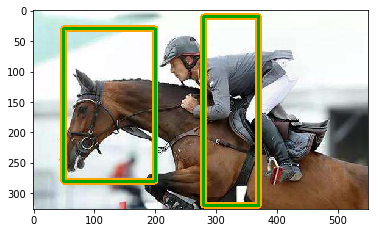

In [27]:
# 回归效果
## 目标
# gt_boxes = tf.constant(gt_boxes, dtype=tf.float32)
# anchors = tf.constant(anchors, dtype=tf.float32)
target = regress_target_tf(anchors, gt_boxes)
## 修正
modify = apply_regress(target, anchors)
## 可视化
img_path = r'C:\Users\Royce\Desktop\time.jpg'
img_new = io.imread(img_path)
modify = modify.eval(session=sess)
print(modify)
print(gt_boxes)
# gt_boxes = gt_boxes.eval(session=sess)
for a in modify:
    x1,y1,x2,y2 = a
    bbox = cv2.rectangle(img_new,(x1,y1),(x2,y2),(255, 165, 0),10) # 橙色的修正anchor
for a in gt_boxes:
    x1,y1,x2,y2 = a
    bbox = cv2.rectangle(img_new,(x1,y1),(x2,y2),(0, 165, 0),3) # 绿色gt
plt.imshow(img_new)